In [29]:
from tqdm import tqdm
import os
from typing import Iterable
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from utils.model import generate_sequence
from torchvision.transforms import v2

from utils.transform import reverse_transform_decorator
from utils.display import show_image_with_bboxes
from utils.iou import iou
from models.simple_decoder import SimpleFaceDetector, info_string as model_info_string
from dataset_classes.vgg_face2_detector import VGGFace2DetectorDataset

In [30]:
device = 'cude' if torch.cuda.is_available() else 'cpu'

In [31]:
MODE = 'train' # 'train' | 'prod'
PATH_TO_SAVED_FILE = None # Путь к сохраненному файлу с параметрами

SAVE_BEST_DIR_PATH = './best_models/'
SAVE_BEST_FILE_NAME = 'best_simple_decoder_{id}_epoch_{epoch}.pt'

EPOCHS = 6


In [32]:
SAVE_BEST_FILE_PATH = os.path.join(SAVE_BEST_DIR_PATH, SAVE_BEST_FILE_NAME)

def is_train():
    return MODE == 'train'

def is_load_from_saved():
    return PATH_TO_SAVED_FILE is not None

if is_load_from_saved():
    load_parameters = torch.load(PATH_TO_SAVED_FILE)

In [33]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((256, 256)),  # Измените размер под вашу модель
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def reverse_transform(image: torch.Tensor, new_image_size: Iterable):
    new_height, new_width = new_image_size
    
    fn = v2.Compose([
        v2.Normalize(mean=(-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), std=(1 / 0.5, 1 / 0.5, 1 / 0.5)),
        v2.Resize((new_height, new_width)),  # Возвращаем к исходному размеру
    ])
    
    return fn(image)

if is_train():
    dataset = VGGFace2DetectorDataset(
        './dataset/images/test',
        './dataset/labels/test',
        transform,
        reverse_transform
    )
    
print(len(dataset))

# test_data = VGGFace2DetectorDataset(
#     './dataset/images/val',
#     './dataset/labels/test/labels'
# )

217111


In [34]:
if is_train():
    train_set, val_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

    batch_size = 64

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [35]:
model = SimpleFaceDetector().to(device)
model_id = generate_sequence(4)

if is_load_from_saved():
    model.load_state_dict(load_parameters['state_model'])
    model_id = load_parameters['model_id']


## Проверка модели

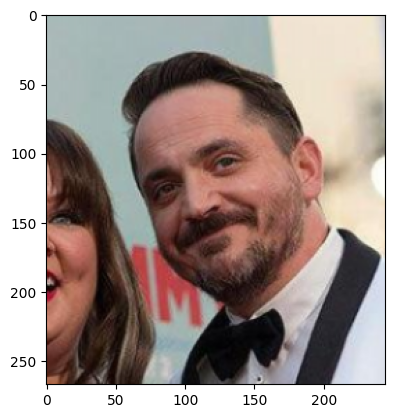

In [36]:
if is_train():
    image, bbox, original_image_size = dataset[16011]

    reverse_func = reverse_transform_decorator(
        reverse_transform, 
        original_image_size
    )

    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи

    predict_bbox = model.forward(data)[0]

    original_image, predict_bbox = reverse_func(image, predict_bbox)
    original_image, bbox = reverse_func(image, bbox)

    show_image_with_bboxes(original_image, [predict_bbox])


In [37]:
# Выбор функции потерь

if is_train():
    loss_model = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, # оптимизатор.
        mode= 'min', # 'max' или 'min" - следим, чтобы отслеживаемый параметр увеличивался (*!
        factor=0.1, # коэффициент, на который будет умножен lr
        patience=2, # кол-во.эпох без улучшения отслеживаемого параметра.
    )
    
    if is_load_from_saved():
        opt.load_state_dict(load_parameters['state_opt'])
        lr_scheduler.load_state_dict(load_parameters['state_lr_scheduler'])

In [38]:

if is_train():
    start_from_epoch = 0
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    lr_list = []
    best_loss = None
    
    if is_load_from_saved():
        # EPOCHS = load_parameters['epoch']['EPOCHS']
        start_from_epoch = load_parameters['epoch']['save_epoch']
        
        train_loss = load_parameters['loss']['train_loss']
        val_loss = load_parameters['loss']['val_loss']
        best_loss = load_parameters['loss']['best_loss']
        
        train_acc = load_parameters['metric']['train_acc']
        val_acc = load_parameters['metric']['val_acc']
        lr_list = load_parameters['lr_list']
        

In [39]:

from utils.model import save_model
from utils.system import delete_file_os, delete_files_with_prefix


if is_train():
    threshold = 0.1
    saved_epoch = None
    # Цикл обучения
    
    for epoch in range(start_from_epoch, EPOCHS):
        
        # Тренировка модели
        train_loop = tqdm(train_loader, leave=False)
        running_train_loss = []
        
        iou_total = 0
        iou_len = 0
        model.train()
        for x, targets, _ in train_loop:
            # Данные
            # x: (batch_size, 3, 256, 256) dtype=float32
            # targets: (batch_size, 4) dtype=float32

            # Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)
            
            # Обратный проход
            opt.zero_grad()
            loss.backward()
            
            # Шаг оптимизации
            opt.step()
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)
            
            for index in range(len(targets)):
                iou_value = iou(pred[index], targets[index])
                iou_total += iou_value
                iou_len += 1
            
            train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}")
            
            # Расчет значения метрики
            # Сохранение значения функции потерь и метрики
        
        running_train_acc = float(iou_total/iou_len)
        train_loss.append(mean_train_loss)
        train_acc.append(running_train_acc)
        
        # Проверка модели (валидация)
        running_val_loss = []
        
        iou_total = 0
        iou_len = 0
        model.eval()
        with torch.no_grad():
            for x, targets, _ in val_loader:
                # Данные
                # x: (batch_size, 3, 256, 256) dtype=float32
                # targets: (batch_size, 4) dtype=float32
                
                # Прямой проход + расчет ошибки модели
                pred = model(x)
                loss = loss_model(pred, targets)
                
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                for index in range(len(targets)):
                    iou_value = iou(pred[index], targets[index])
                    iou_total += iou_value
                    iou_len += 1
                    
            running_val_acc = float(iou_total/iou_len)
            
            val_loss.append(mean_val_loss)
            val_acc.append(running_val_acc)
                
            # Расчет значения метрики
            # Сохранение значения функции потерь и метрики
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        lr_list.append(lr)
        
        if best_loss is None:
            best_loss = mean_val_loss
        
        if mean_val_loss < best_loss - best_loss * threshold:
            best_loss = mean_val_loss
            
            if saved_epoch is not None:
                prefix = SAVE_BEST_FILE_NAME.split('{id}')[0] + '{id}'
                delete_files_with_prefix(
                    SAVE_BEST_DIR_PATH,
                    prefix.format(id=model_id)
                )
            
            saved_epoch = epoch+1
            save_model(
                file_path=SAVE_BEST_FILE_PATH,
                str_info=model_info_string,
                model=model,
                model_id=model_id,
                opt=opt,
                lr_scheduler=lr_scheduler,
                train_loss=train_loss,
                val_loss=val_loss,
                best_loss=best_loss,
                train_acc=train_acc,
                val_acc=val_acc,
                lr_list=lr_list,
                EPOCHS=EPOCHS,
                epoch=epoch+1,
            )
            print(f'Ha эпoxe - {epoch+1}, сохранена модель со значением функции потерь на валидации - {mean_val_loss: 4f}', end='\n\n')
            
        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}, train_acc={running_train_acc: .4f}, val_loss={mean_val_loss: .4f}, val_acc={running_val_acc: .4f}, lr={lr}")

KeyboardInterrupt: 

In [ ]:
if is_train():
    plt.plot(lr_list)
    plt.show()

In [ ]:
if is_train():
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['loss_train', 'loss_val'])
    plt.show()

In [ ]:
if is_train():
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.legend(['acc_train', 'acc_val'])
    plt.show()

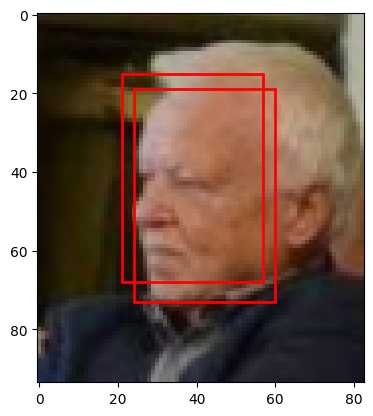

In [ ]:
if not is_train():
    image, bbox, original_image_size = dataset[405]

    reverse_func = reverse_transform_decorator(
        reverse_transform, 
        original_image_size
    )

    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи

    predict_bbox = model.forward(data)[0]

    original_image, predict_bbox = reverse_func(image, predict_bbox)
    original_image, bbox = reverse_func(image, bbox)

    show_image_with_bboxes(original_image, [predict_bbox])